In [2]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

2023-12-22 18:18:34.134490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 18:18:34.134557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 18:18:34.255592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 18:18:34.496308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 18:18:36.167950: W tensorflow/compiler/tf2

In [3]:
breed_list = os.listdir("./images/Images")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("./images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


In [4]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

n02091134-whippet


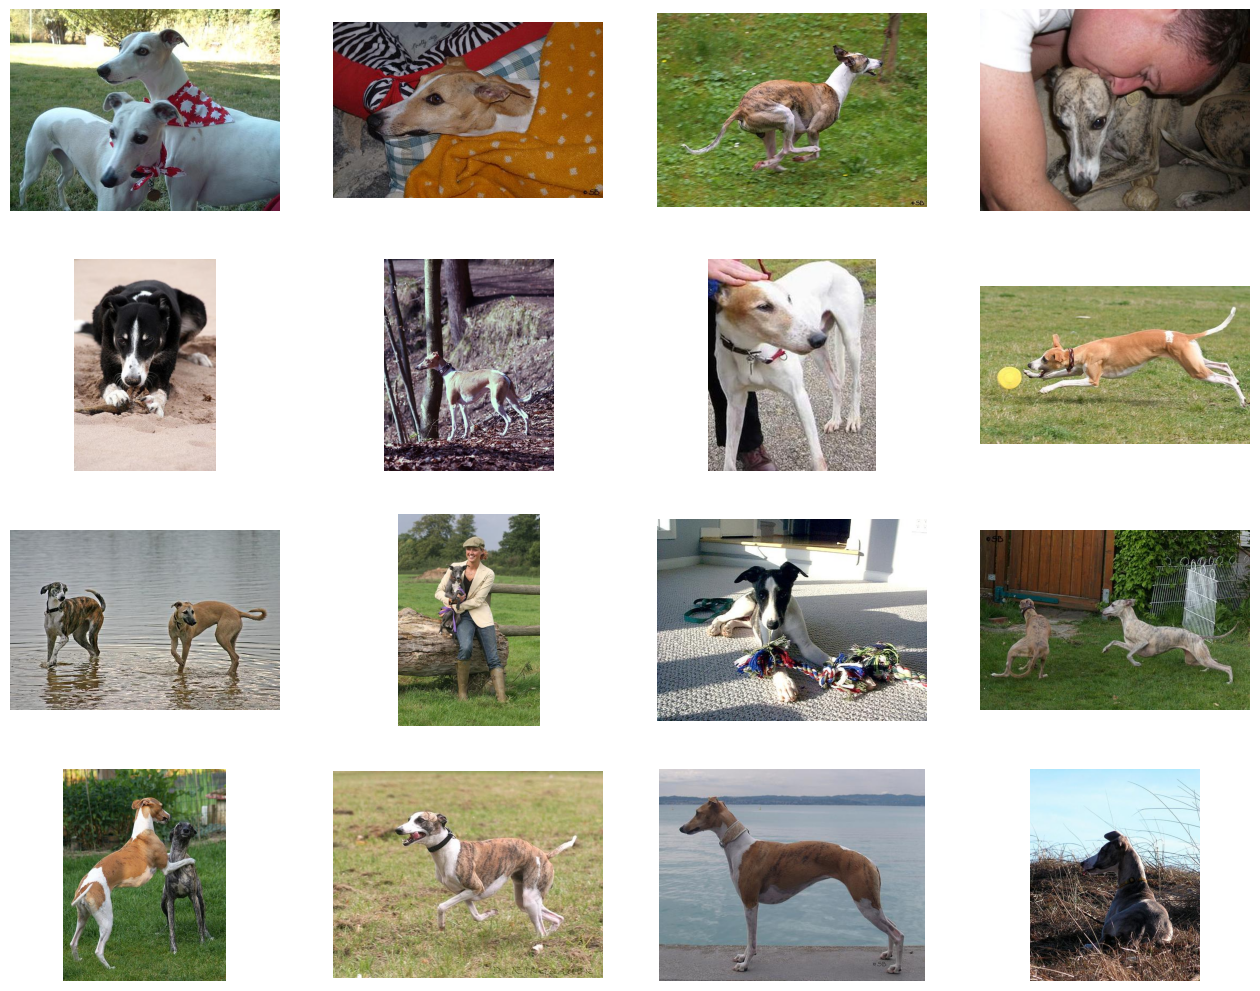

In [5]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "./images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show//4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
print(breed_list[0])
show_dir_images(breed_list[0], 16)

In [9]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('./annotations/Annotation/{}'.format(breed)):
        img = Image.open('./images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('./annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
CPU times: user 1min 2s, sys: 3.27 s, total: 1min 5s
Wall time: 1min 5s


In [6]:
from keras.utils import to_categorical
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = to_categorical(targets, num_classes=num_classes)

In [7]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [8]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

In [9]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights='imagenet',
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

2023-12-22 18:19:00.315470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 18:19:00.655236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 18:19:00.655752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 18:19:00.657803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 18:19:00.658323: I external/local_xla/xla/stream_executor

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
for layer in model.layers[:-6]:
    layer.trainable = False

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20)

Epoch 1/20
547/547 [==============================] - 115s 200ms/step - loss: 2.6089 - acc: 0.3349 - f1_m: 0.2559 - precision_m: 0.5041 - recall_m: 0.1807 - val_loss: 0.7938 - val_acc: 0.7638 - val_f1_m: 0.7286 - val_precision_m: 0.8655 - val_recall_m: 0.6325
Epoch 2/20
547/547 [==============================] - 111s 203ms/step - loss: 1.6178 - acc: 0.5340 - f1_m: 0.5109 - precision_m: 0.6971 - recall_m: 0.4065 - val_loss: 0.6802 - val_acc: 0.7800 - val_f1_m: 0.7665 - val_precision_m: 0.8624 - val_recall_m: 0.6922
Epoch 3/20
547/547 [==============================] - 122s 222ms/step - loss: 1.4501 - acc: 0.5838 - f1_m: 0.5740 - precision_m: 0.7364 - recall_m: 0.4739 - val_loss: 0.6402 - val_acc: 0.7875 - val_f1_m: 0.7774 - val_precision_m: 0.8684 - val_recall_m: 0.7058
Epoch 4/20
547/547 [==============================] - 122s 222ms/step - loss: 1.3735 - acc: 0.5983 - f1_m: 0.5932 - precision_m: 0.7426 - recall_m: 0.4968 - val_loss: 0.6373 - val_acc: 0.8060 - val_f1_m: 0.7852 - val_pre

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.figure()
plt.title('Training and validation f1')
plt.plot(epochs, f1, 'red', label='Training f1')
plt.plot(epochs, val_f1, 'blue', label='Validation f1')
plt.legend()

plt.figure()
plt.title('Training and validation precision')
plt.plot(epochs, precision, 'red', label='Training precision')
plt.plot(epochs, val_precision, 'blue', label='Validation precision')
plt.legend()

plt.figure()
plt.title('Training and validation recall')
plt.plot(epochs, recall, 'red', label='Training recall')
plt.plot(epochs, val_recall, 'blue', label='Validation recall')
plt.legend()

plt.show()

In [17]:
for layer in model.layers[:]:
    layer.trainable = True

# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 1.1601 - acc: 0.6664 - f1_m: 0.6739 - precision_m: 0.7834 - recall_m: 0.5938
Epoch 1: val_acc improved from -inf to 0.82831, saving model to dog_breed_classifier_model.h5
547/547 [==============================] - 90s 165ms/step - loss: 1.1601 - acc: 0.6664 - f1_m: 0.6739 - precision_m: 0.7834 - recall_m: 0.5938 - val_loss: 0.5630 - val_acc: 0.8283 - val_f1_m: 0.8197 - val_precision_m: 0.8907 - val_recall_m: 0.7615 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.1538 - acc: 0.6691 - f1_m: 0.6762 - precision_m: 0.7853 - recall_m: 0.5963
Epoch 2: val_acc improved from 0.82831 to 0.82993, saving model to dog_breed_classifier_model.h5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
547/547 [==============================] - 100s 182ms/step - loss: 1.1538 - acc: 0.6691 - f1_m: 0.6762 - precision_m: 0.7853 - recall_m: 0.5963 - val_loss: 0.5744 - val_acc: 0.

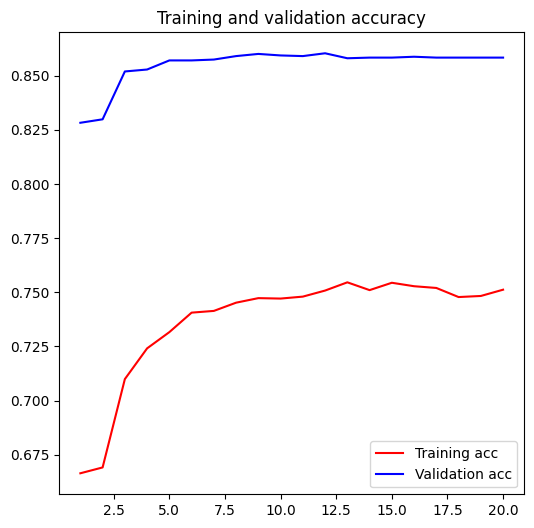

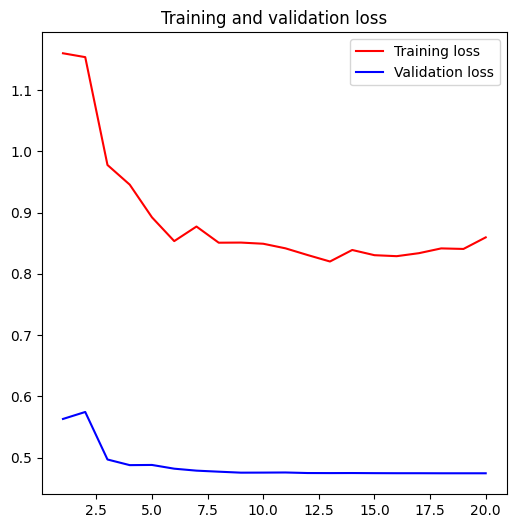

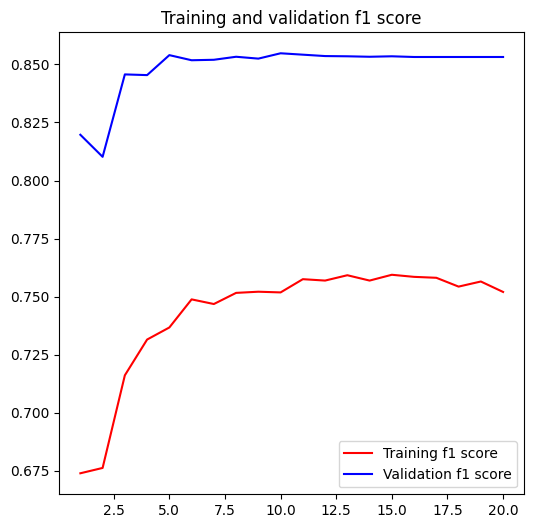

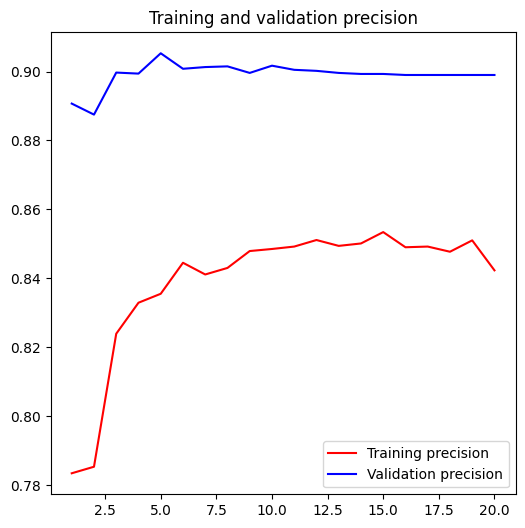

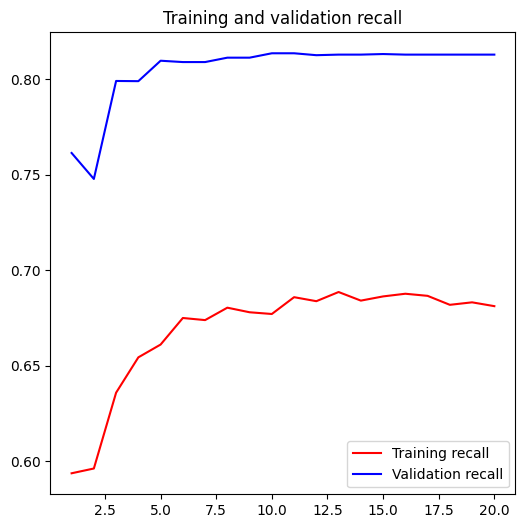

In [17]:
plt.rcParams['figure.figsize'] = (6,6)

acc = [0.6664,0.6691,0.7099,0.7241,0.7316,0.7406,0.7414,0.7452,0.7473,0.7471,0.7480,0.7508,0.7546,0.7510,0.7544,0.7528,0.7520,0.7478,0.7483,0.7512]
val_acc = [0.8283,0.8299,0.8520,0.8529,0.8571,0.8571,0.8575,0.8591,0.8601,0.8594,0.8591,0.8604,0.8581,0.8584,0.8584,0.8588,0.8584,0.8584,0.8584,0.8584]
f1 = [0.6739,0.6762,0.7161,0.7315,0.7367,0.7488,0.7468,0.7516,0.7521,0.7518,0.7575,0.7569,0.7592,0.7569,0.7594,0.7585,0.7581,0.7543,0.7565,0.7520]
val_f1 = [0.8197,0.8102,0.8457,0.8454,0.8540,0.8518,0.8520,0.8533,0.8525,0.8548,0.8542,0.8536,0.8535,0.8533,0.8535,0.8532,0.8532,0.8532,0.8532,0.8532]
precision = [0.7834,0.7853,0.8239,0.8329,0.8355,0.8445,0.8411,0.8430,0.8479,0.8485,0.8492,0.8511,0.8494,0.8501,0.8534,0.8490,0.8492,0.8477,0.8510,0.8423]
val_precision = [0.8907,0.8875,0.8997,0.8994,0.9053,0.9008,0.9013,0.9015,0.8996,0.9017,0.9005,0.9002,0.8996,0.8993,0.8993,0.8990,0.8990,0.8990,0.8990,0.8990]
recall = [0.5938,0.5963,0.6360,0.6545,0.6612,0.6751,0.6740,0.6805,0.6781,0.6772,0.6860,0.6839,0.6887,0.6842,0.6864,0.6878,0.6867,0.6820,0.6833,0.6813]
val_recall = [0.7615,0.7479,0.7992,0.7991,0.8098,0.8091,0.8091,0.8114,0.8114,0.8137,0.8137,0.8127,0.8130,0.8130,0.8133,0.8130,0.8130,0.8130,0.8130,0.8130]
loss = [1.1601,1.1538,0.9777,0.9456,0.8922,0.8534,0.8772,0.8508,0.8510,0.8491,0.8416,0.8306,0.8201,0.8389,0.8304,0.8288,0.8337,0.8415,0.8406,0.8595]
val_loss = [0.5630,0.5744,0.4968,0.4876,0.4879,0.4818,0.4786,0.4769,0.4753,0.4754,0.4756,0.4747,0.4746,0.4747,0.4745,0.4744,0.4744,0.4743,0.4743,0.4743]
epochs = range(1, len(loss) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.figure()
plt.title('Training and validation f1 score')
plt.plot(epochs, f1, 'red', label='Training f1 score')
plt.plot(epochs, val_f1, 'blue', label='Validation f1 score')
plt.legend()

plt.figure()
plt.title('Training and validation precision')
plt.plot(epochs, precision, 'red', label='Training precision')
plt.plot(epochs, val_precision, 'blue', label='Validation precision')
plt.legend()

plt.figure()
plt.title('Training and validation recall')
plt.plot(epochs, recall, 'red', label='Training recall')
plt.plot(epochs, val_recall, 'blue', label='Validation recall')
plt.legend()

plt.show()

In [18]:
print(f"Maximum validation accuracy = {max(val_acc)}")
print(f"Maximum validation precision = {max(val_precision)}")
print(f"Maximum validation recall = {max(val_recall)}")
print(f"Maximum validation f1 score = {max(val_f1)}")

Maximum validation accuracy = 0.8604
Maximum validation precision = 0.9053
Maximum validation recall = 0.8137
Maximum validation f1 score = 0.8548


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(val_gen, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(train_gen, y_pred_bool))

In [27]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 [==============================] - 0s 41ms/step
100.00% 	 malinois
0.00% 	 German_shepherd
0.00% 	 dingo
0.00% 	 kelpie
0.00% 	 Norwegian_elkhound


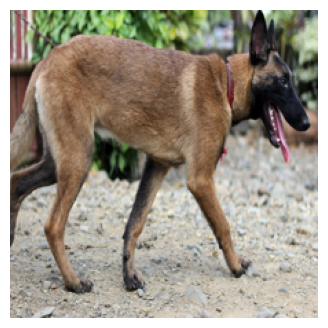

In [28]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

1/1 [==============================] - 0s 41ms/step
86.42% 	 Pembroke
12.97% 	 Cardigan
0.32% 	 dingo
0.15% 	 kelpie
0.08% 	 basenji


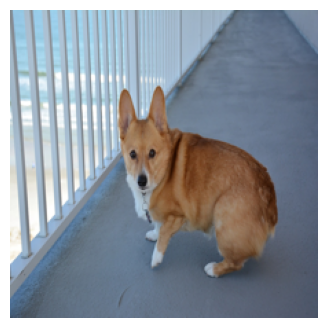

In [22]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

1/1 [==============================] - 0s 43ms/step
98.14% 	 Chihuahua
1.62% 	 toy_terrier
0.23% 	 miniature_pinscher
0.01% 	 Boston_bull
0.00% 	 Cardigan


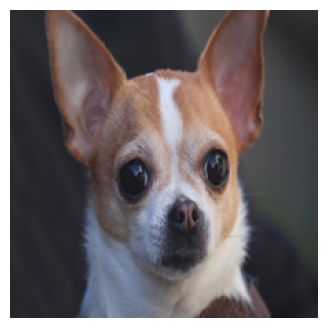

In [23]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

1/1 [==============================] - 0s 34ms/step
99.94% 	 vizsla
0.03% 	 Rhodesian_ridgeback
0.02% 	 Weimaraner
0.01% 	 redbone
0.00% 	 Chesapeake_Bay_retriever


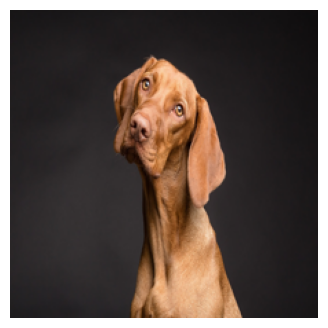

In [24]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")